In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'matplotlib'

## Sub Duration vs Churn Rate (using past month viewership) 

In [2]:
df = pd.read_csv('streamtime_test_agg.csv', error_bad_lines=False, sep='\t')
df.columns = df.columns.str.lower()
df.head()

,hbo_uuid,provider_user_id,sub_month,is_cancel,is_reconnect,ttl_stream_hrs
0,873ba6fe1aa28c01396541cf1b1d652a987b73d3caeb80...,hqLiJrJOUqDZWn0vItOHJlw3ZJGTgvayqbDVBU9Ug6g=,1,False,False,13.277222
1,be4efeff6f8b7b6d8786b8118cc4c75aae809e614fed63...,P9CBMS4paCo4iWYB0i1xnyTPAob16jpOzzTppjjZR/k=,14,False,False,29.404167
2,7b37bc933267c65438284ec4732559ab407ab76d9c112a...,XQpfAmkgwARPwT6xnfW9d1MDdPafMksJdtOh+hZre+4=,15,True,False,112.493333
3,28d8a71ea9f038bdeb5966018f9f08a566f45a29cddc19...,IW5csdP6EHQHx6Hcwi14lyXnVqNou93jdBvOSNieo9Y=,2,False,False,755.380556
4,4bc67ac626e5465d0aa2d9ac4fad4dfc1799b28c0560db...,Mf5Vx3HM6reFnvJwdPi6ya4Qc44o8leytDQobVURkiA=,1,False,False,71.177222


In [8]:
df.groupby(['sub_month'])['is_cancel'].mean().values

array([0.16496271, 0.11736431, 0.10495825, 0.08306961, 0.06763904,
       0.06959595, 0.06568037, 0.05037328, 0.05056635, 0.05084164,
       0.04441043, 0.04116373, 0.03249469, 0.02622859, 0.02892524])

In [9]:
upper_= {}
columns = ['ttl_stream_hrs']
#df = df.loc[df['ttl_stream_hrs']>0,:]
upper_ = df['ttl_stream_hrs'].quantile(0.99)
#lower_ = df['ttl_stream_hrs'].quantile(0.01)
#df = df.loc[df['ttl_stream_hrs'].between(lower_, upper_), :]
df = df.loc[df['ttl_stream_hrs']<=upper_, :]  
df = df.reset_index(drop = True)


In [10]:
nbins = 100
df['ttl_stream_hrs_bin'] = pd.qcut(df['ttl_stream_hrs'], np.linspace(0,1,nbins))

df['ttl_stream_hrs_bin'] = df['ttl_stream_hrs_bin'].apply(lambda x: (x.left+x.right)/2)
df['ttl_stream_hrs_bin'] = df['ttl_stream_hrs_bin'].astype('float')
df['churn'] = 1*df['is_cancel'] 
df['retention'] = 1-1*df['is_cancel'] 

<AxesSubplot:xlabel='ttl_stream_hrs_bin'>

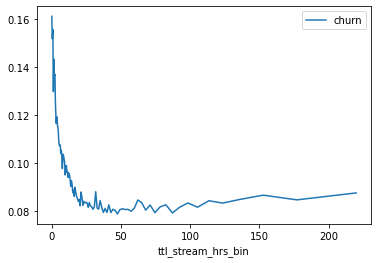

In [29]:
prob = df.groupby(['ttl_stream_hrs_bin']).agg({'churn':'mean'})
(prob).plot()

In [27]:
tmp = df.groupby(['ttl_stream_hrs_bin']).agg({'churn':'mean'})
tmp[tmp.index<=50]

,churn
ttl_stream_hrs_bin,
0.20215,0.161278
0.57350,0.151889
0.97550,0.155800
1.34750,0.129841
1.65550,0.143336
...,...
42.79150,0.079292
44.29950,0.080677
45.88050,0.080246


<AxesSubplot:>

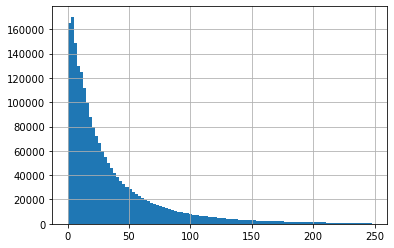

In [24]:
df['ttl_stream_hrs'].hist(bins = 100)

In [7]:
# baseline
tmp = prob.loc[prob['ttl_stream_hrs_bin']==0.20215,:]
tmp['ttl_churn'] = tmp['churn']*tmp['retention']
1-tmp['ttl_churn'].sum()/tmp['retention'].sum()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.8387216994316593

In [8]:
# total avg
tmp = prob.copy()
tmp['ttl_churn'] = tmp['churn']*tmp['retention']
1-tmp['ttl_churn'].sum()/tmp['retention'].sum()

0.9052575195171845

### Retention rate over sub cohort

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


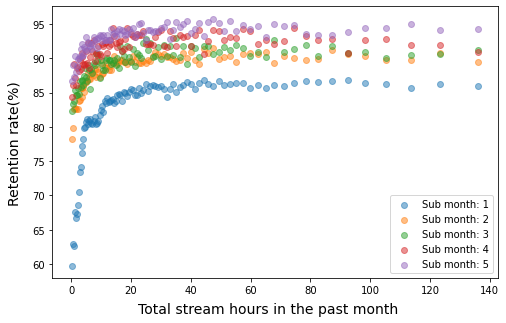

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
start_N=1
end_N=5
label_list = []
for n in range(start_N,end_N+1):
    tmp = prob.loc[prob['sub_month']==n, :]
    tmp.index = tmp['ttl_stream_hrs_bin'].astype('float')
    tmp = tmp[tmp.index<150]
    label = f'Sub month: {n}'
    ax.scatter(x=tmp['ttl_stream_hrs_bin'], y=100 - 100*tmp['churn'], alpha = 0.5)
    #ax.fill_between(tmp.index, 100-100*tmp['approx_lowerbound'], 100-100*tmp['approx_upperbound'], alpha = 0.2, label = label)
    label_list.append(label)
    
ax.set_xlabel = 'Total stream hours'
ax.set_ylabel = 'Churn rate'
ax.legend(label_list, loc='lower right')
fig.text(0.5, 0.04, 'Total stream hours in the past month', size = 14, ha='center', va='center')
fig.text(0.06, 0.5, 'Retention rate(%)', rotation = 90, size = 14, ha='center', va='center')
fig.show()

In [10]:
tmp = prob.loc[prob['sub_month']==1, :]

# Estimation 

### Dont work: Linear Twedie regression, Logistic regression, Kernel ridge regression

In [11]:
prob_tmp = prob.loc[prob['sub_month']==15, :]

In [12]:
def weibull_curve(x, c, loc, scale, int_):
    return c*((x-loc)**(c-1))*(np.exp(-(x-loc)**c))/scale + int_

In [13]:
prob_tmp['retention'].sum()

32537

1 0.2815278801432517 0.3201541401634529
zero point 0.5600453818286636
approx. upper point 0.8609401765561936
2 0.09831616563835575 0.14238890216079514
zero point 0.7824975142846308
approx. upper point 0.9029743018625982
3 0.05444206766269078 0.1204041188497843
zero point 0.8243430817549438
approx. upper point 0.9118167560484208
4 0.04226538112515386 0.10627598426416232
zero point 0.8538926308570647
approx. upper point 0.9281637322967904
5 0.048203255203011816 0.10281559957130516
zero point 0.8686896745236733
approx. upper point 0.9442628679395617
6 0.03657980436050682 0.08882681895799613
zero point 0.8770178349167456
approx. upper point 0.9397211517020987
7 0.02911194306577266 0.09328791170593179
zero point 0.8832400122955202
approx. upper point 0.9444401545307551
8 0.03620780129692818 0.08006496843221306
zero point 0.8994063647392234
approx. upper point 0.9576227944785607
9 0.012402112772958045 0.06859819707792841
zero point 0.91747997078224
approx. upper point 0.95798286373629


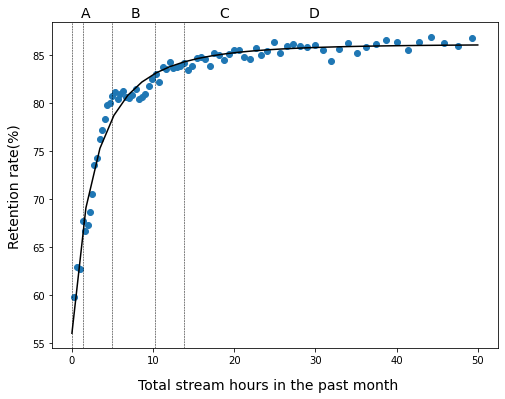

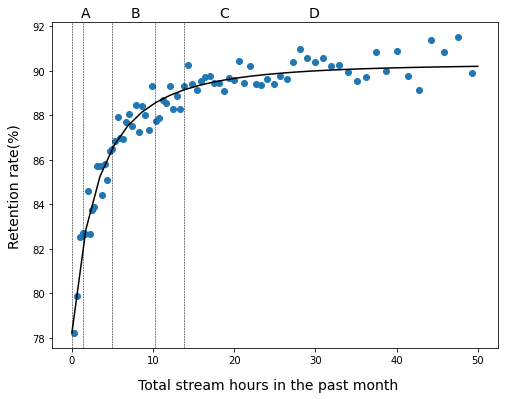

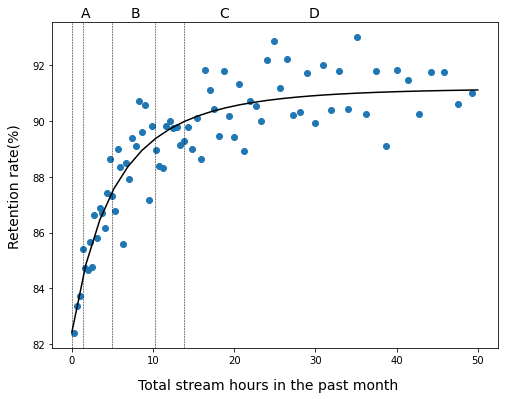

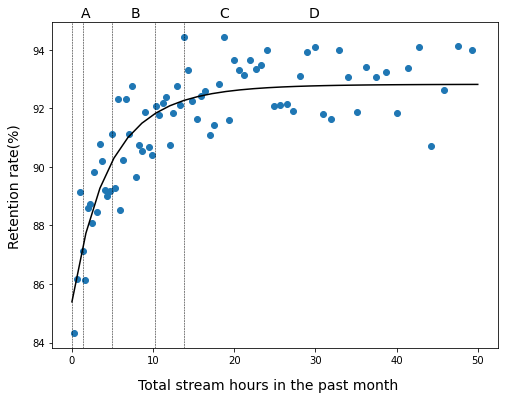

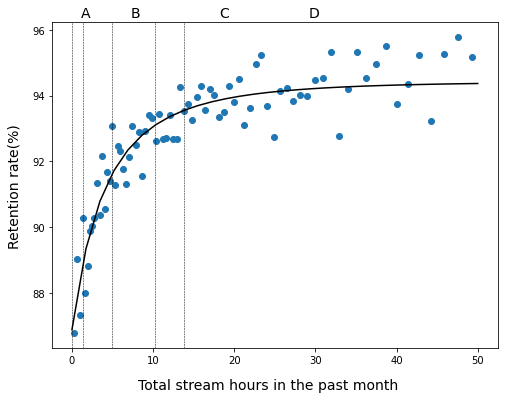

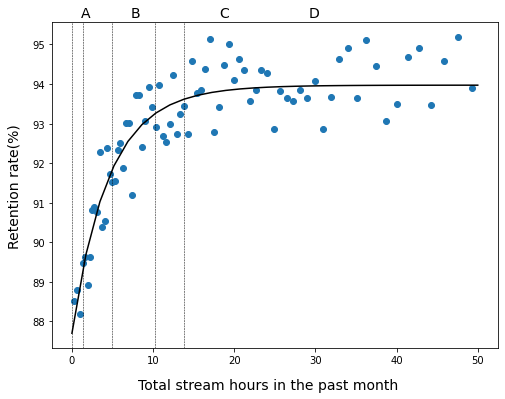

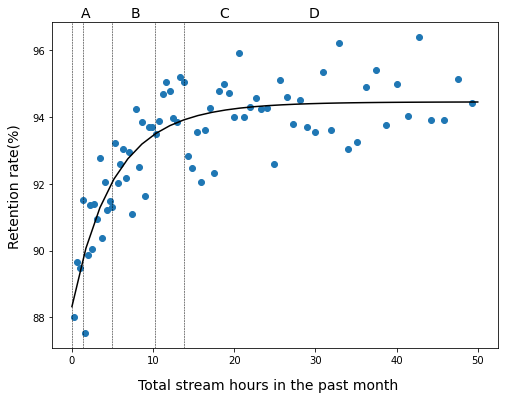

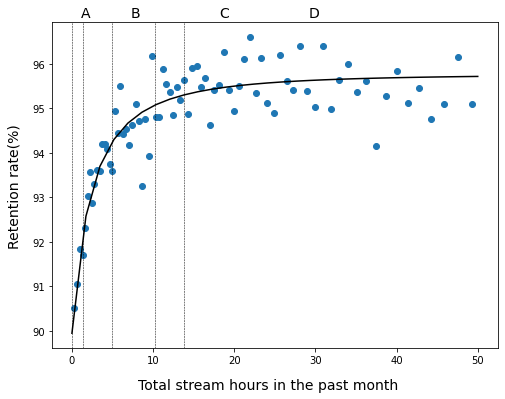

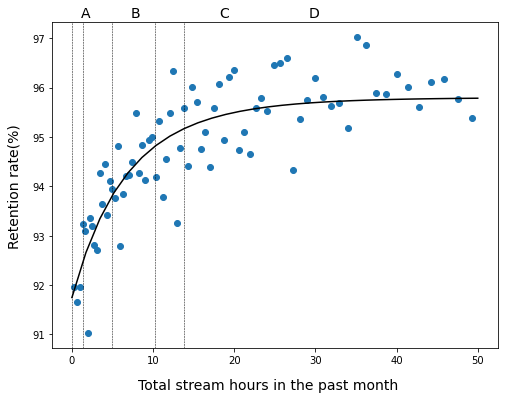

In [14]:
max_ = 50
rec = {'n':[], 'popt':[]}
for n in range(1,10): 
    # estimation and plotting
    prob_tmp = prob.loc[prob['sub_month']==n, :]
    xdata = prob_tmp.ttl_stream_hrs_bin.astype('float').values
    ydata = prob_tmp.churn.values
    popt_no, pcov_no = curve_fit(weibull_curve, xdata, ydata, p0 = [0.1, 0.1, 0.1, 0], bounds = (-30, 30))
    rec['popt'].append(popt_no)
    rec['n'].append(n)

    prob_tmp = prob.loc[((prob['sub_month']==n) & (prob['ttl_stream_hrs_bin']<= max_)), :]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(np.linspace(0,max_,30), 100*(1-weibull_curve(np.linspace(0,max_,30), *popt_no)), color = 'black')
    y_val = 100*(1-prob_tmp['churn']).values
    x_val = prob_tmp['ttl_stream_hrs_bin'].values
    ax.scatter(x_val, y_val)
    #ax.set_ylim(35, 100)
    ax.axvline(x = 0, linestyle = '--', color = 'black', linewidth = 0.5)
    ax.axvline(x = 1.32, linestyle = '--', color = 'black', linewidth = 0.5)
    ax.axvline(x = 4.90, linestyle = '--', color = 'black', linewidth = 0.5)
    ax.axvline(x = 10.21, linestyle = '--', color = 'black', linewidth = 0.5)
    ax.axvline(x = 13.83, linestyle = '--', color = 'black', linewidth = 0.5)
    fig.text(0.5, 0.04, 'Total stream hours in the past month', size = 14, ha='center', va='center')
    fig.text(0.06, 0.5, 'Retention rate(%)', rotation = 90, size = 14, ha='center', va='center')
    fig.text(0.185, 0.9, 'A', rotation = 0, size = 14, ha='center', va='center')
    fig.text(0.27, 0.9, 'B', rotation = 0, size = 14, ha='center', va='center')
    fig.text(0.425, 0.9, 'C', rotation = 0, size = 14, ha='center', va='center')
    fig.text(0.58, 0.9, 'D', rotation = 0, size = 14, ha='center', va='center')
    
    # calculate std to see if this month has to be considered
    output = 1-weibull_curve([0,100], *popt_no)
    fin_p = (output[0] + output[1])/2
    std = (((fin_p*(1-fin_p))*(2/(prob_tmp['retention'].sum()/nbins)))**0.5)

    output = 1-weibull_curve([0,100], *popt_no)
    upper_ = (output[1] - output[0] + 2*std)
    lower_ = (output[1] - output[0] - 2*std)
    
    print(n, lower_, upper_)
    print('zero point {0}'.format(1 - weibull_curve(0, *popt_no)))
    print('approx. upper point {0}'.format(1 - weibull_curve(200, *popt_no)))
    if ((upper_>=0) & (lower_<=0)) :
        print('Not Significant')
        break

max_n = n -1

In [15]:
rec['popt'][2]

array([ 0.46665389, -9.28560279,  0.0960096 ,  0.08818169])

In [16]:
x = np.linspace(0,max_,30)
y = 100*(1-weibull_curve(np.linspace(0,max_,30), *popt_no))

<AxesSubplot:>

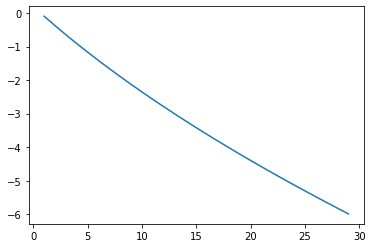

In [17]:
np.log(pd.Series(y).diff()).plot()

# Revenue Calculation

In [18]:
# use average retention rate for the future

In [19]:
tmp = df.groupby(['hbo_uuid'])['sub_month'].nunique()

In [20]:
df.head()

,hbo_uuid,provider_user_id,sub_month,is_cancel,is_reconnect,ttl_stream_hrs,ttl_stream_hrs_bin,churn,retention
0,873ba6fe1aa28c01396541cf1b1d652a987b73d3caeb80...,hqLiJrJOUqDZWn0vItOHJlw3ZJGTgvayqbDVBU9Ug6g=,1,False,False,13.277222,13.3755,0,1
1,be4efeff6f8b7b6d8786b8118cc4c75aae809e614fed63...,P9CBMS4paCo4iWYB0i1xnyTPAob16jpOzzTppjjZR/k=,14,False,False,29.404167,29.0210,0,1
2,7b37bc933267c65438284ec4732559ab407ab76d9c112a...,XQpfAmkgwARPwT6xnfW9d1MDdPafMksJdtOh+hZre+4=,15,True,False,112.493333,113.6120,1,0
3,4bc67ac626e5465d0aa2d9ac4fad4dfc1799b28c0560db...,Mf5Vx3HM6reFnvJwdPi6ya4Qc44o8leytDQobVURkiA=,1,False,False,71.177222,71.1170,0,1
4,ef5b1a54d464cf2a351276b7e1209cb37c94fb13641ffe...,hCjevpu5sjFuK476/z4HhcJk/R6re4OsGMol0n6gvxM=,2,False,False,30.206667,29.9410,0,1


In [21]:
avg_retention = 1- df.groupby(['sub_month'])['churn'].mean()

In [22]:
avg_retention

sub_month
1     0.835011
2     0.882475
3     0.895083
4     0.916798
5     0.932314
6     0.930342
7     0.934147
8     0.949595
9     0.949469
10    0.948990
11    0.955687
12    0.958666
13    0.967468
14    0.973862
15    0.970864
Name: churn, dtype: float64

In [23]:
def n_month_state_prob(p, cur_n, avg_retention, max_n = 15):
    base = p
    total = p
    for n in range(cur_n+1, max_n+1):
        base = base * avg_retention[n]
        total = total + base
        
    return total

In [24]:
def ttl_churn_pct(p, cur_n, avg_retention, max_n = 15):
    total = p
    print(p)
    for n in range(cur_n+1, max_n + 1):
        print(avg_retention[n])
        total *= avg_retention[n]
    return 1 - total

In [25]:
n_month_state_prob(0.51, 1, avg_retention, max_n = 15) - n_month_state_prob(0.5, 1, avg_retention, max_n = 15)

0.09113676356958766

In [26]:
n_month_state_prob(1, 1, avg_retention, max_n = 15)

9.113676356958704

In [27]:
avg_retention

sub_month
1     0.835011
2     0.882475
3     0.895083
4     0.916798
5     0.932314
6     0.930342
7     0.934147
8     0.949595
9     0.949469
10    0.948990
11    0.955687
12    0.958666
13    0.967468
14    0.973862
15    0.970864
Name: churn, dtype: float64

In [28]:
0.01 + 0.01*avg_retention[2] + 0.01*avg_retention[2]*avg_retention[3]

0.026723623827685714

In [29]:
start_hours_tmp = [0, 1.32, 4.90, 10.21]
end_hours_tmp = [1.32, 4.90, 10.21, 13.83]
start_retention = (1 - weibull_curve(start_hours_tmp, *rec['popt'][0])) 
end_retention = (1 - weibull_curve(end_hours_tmp, *rec['popt'][0]))

In [30]:
9.113676356958704*(end_retention - start_retention)

array([0.99184708, 1.03634159, 0.43549615, 0.11134829])

In [31]:
(end_retention - start_retention)

array([0.10883062, 0.11371279, 0.0477849 , 0.01221771])

In [32]:
df_full.groupby(['hbo_uuid'])['ttl_stream_hrs'].sum().quantile([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

NameError: name 'df_full' is not defined

In [ ]:
df_full.groupby(['sub_month'])['hbo_uuid'].nunique()

In [ ]:
df_uuid_max_date = pd.read_csv('sub_max_date.csv', sep='\t', index_col =0)

In [ ]:
df_uuid_max_date.head()

In [ ]:
monthly_fee = 14.99
ttl_revenue = pd.DataFrame()

#for date in ['2022-02-10', '2022-03-10']:
for date in ['2022-03-02_v1']:
    print(date)
    df_full = pd.read_csv('df_date_{}.csv'.format(date), error_bad_lines=False, sep=',', index_col=0)
    df_full.columns = df_full.columns.str.lower()
    df_full = df_full.loc[df_full['sub_month'].between(0,20),:]
    df_full['churn'] = 1*df_full['is_cancel'] 
    df_full['retention'] = 1-1*df_full['is_cancel'] 

    df_full['revenue_dist'] = 0
    df_full['revenue_dist_cur'] = 0
    df_full['revenue_dist_expect'] = 0
    df_full['retention_impr'] = 0
    df_full['prev_start_cum_hrs'] = df_full['prev_start_cum_hrs'].fillna(0)
    df_full = df_full.loc[df_full['sub_month']<=max_n,:]

    for cur_n in range(1, max_n + 1):
        print(f'currently calculating sub month: {cur_n}')
        # get start/end time inside the n sub month data
        df_full_tmp = df_full.loc[df_full['sub_month']==cur_n,:]
        start_hours = df_full_tmp['prev_start_cum_hrs']
        end_hours = df_full_tmp['cum_ttl_stream_hr']

        # get the right model to estimate the right prob
        start_retention = (1 - weibull_curve(start_hours, *rec['popt'][cur_n - 1])) 
        end_retention = (1 - weibull_curve(end_hours, *rec['popt'][cur_n - 1]))

        # calculate the unit revenue imporvement
        unit_pct_money = n_month_state_prob(1, cur_n, avg_retention)


        # get the revenue for each title in each provider id
        df_full_tmp['retention_impr'] = end_retention - start_retention
        df_full_tmp['revenue_dist_cur'] = monthly_fee*df_full_tmp['retention_impr']
        df_full_tmp['revenue_dist_expect'] = (unit_pct_money-1)*df_full_tmp['revenue_dist_cur']
        # merge the value back
        df_full.loc[df_full_tmp.index, 'revenue_dist_expect'] = df_full_tmp['revenue_dist_expect']
        df_full.loc[df_full_tmp.index, 'revenue_dist_cur'] = df_full_tmp['revenue_dist_cur']
        df_full.loc[df_full_tmp.index, 'retention_impr'] = df_full_tmp['retention_impr']

    df_full['date'] = date.split('_')[0]
    tmp_revenue = df_full.groupby(['title_name', 'match_id']).\
        agg({'revenue_dist_cur':'sum'}).sort_values('revenue_dist_cur', ascending = False).reset_index()
    
    ttl_revenue = pd.concat([ttl_revenue, tmp_revenue])


In [ ]:
ttl_revenue['title_name_id'] = ttl_revenue['title_name'] + '-' + ttl_revenue['match_id']
ttl_revenue_pivot = ttl_revenue.pivot(index = 'title_name_id', columns = 'date', values = 'revenue_dist').sort_values('2022-02-10', ascending = False).fillna(0)


In [ ]:
np.log(ttl_revenue_pivot.transpose().iloc[:,:10]).plot(rot= 90)
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
ttl_revenue.groupby('date')['revenue_dist'].sum()

In [ ]:
df_test = pd.read_csv('streamtime_test_2022-02-16.csv', error_bad_lines=False, sep='\t')
df_test.columns = df_test.columns.str.lower()

In [ ]:
df_test.loc[df_test['last_session_last_month_flag']==1,'hbo_uuid'].nunique()

In [ ]:
df_test['hbo_uuid'].nunique()

# New Session

In [ ]:
tmp_revenue = df_full.groupby(['title_name', 'match_id']).agg({'revenue_dist':'sum'
                                                                   , 'retention_impr':'mean'
                                                                   , 'title_session':'median'
                                                                   , 'min_request_time_gmt':'count'
                                                                   , 'ttl_stream_hrs':'mean'}).sort_values('revenue_dist', ascending = False).reset_index()

tmp_revenue = tmp_revenue.rename(columns= {'title_session':'title_session_median'
                                              , 'min_request_time_gmt':'session_count'
                                              , 'ttl_stream_hrs': 'ttl_stream_hrs_mean'})

In [ ]:
revenue_sub_month = df_full.groupby(['title_name', 'match_id', 'sub_month'])['revenue_dist'].sum().reset_index()

In [ ]:
revenue_sub_month['title_name_id'] = revenue_sub_month['title_name'] + '-' + revenue_sub_month['match_id'] 

In [ ]:
revenue_pivot = revenue_sub_month.pivot(index = 'title_name_id', columns = 'sub_month', values = 'revenue_dist')


In [ ]:
revenue_pivot['ttl_revenue'] = revenue_pivot.sum(axis=1)

In [ ]:
revenue_pivot = revenue_pivot.sort_values('ttl_revenue')

In [ ]:
revenue_pivot = revenue_pivot[list(range(1,13))].fillna(0)

In [ ]:
revenue_pivot.tail(20).plot.barh(stacked = True)

In [ ]:
ttl_revenue.groupby(['date'])['revenue_dist'].idxmax()

In [ ]:
ttl_revenue = ttl_revenue.reset_index(drop = True)

In [ ]:
ttl_revenue.loc[ttl_revenue.groupby(['date'])['revenue_dist'].idxmax(),:].sort_values('revenue_dist', ascending = False)


# Sagemaker output analysis

In [ ]:
revenue_full = pd.read_csv('ttl_revenue_date_01to06.csv')
revenue_full['title_name_id'] = revenue_full['title_name'] + '-' + revenue_full['match_id']
revenue = revenue_full.groupby(['title_name_id', 'date'])['revenue_dist'].sum().reset_index()

In [ ]:
revenue_ttl = revenue_full.groupby(['title_name_id'])['revenue_dist'].mean().sort_values(ascending = False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
tmp = np.log10(revenue.loc[revenue['title_name_id'].isin(revenue_ttl.iloc[:5].index),:]\
    .pivot(index='date', columns = 'title_name_id', values = 'revenue_dist'))
tmp.columns = [col.split('-')[0] for col in tmp.columns]

for col in tmp.columns:
    line_df= tmp[col]
    line_df.index.name = None
    line_df.plot(rot= 90)
    
plt.legend(loc= 'lower left')
fig.text(0.5, -0.1, 'Date', size = 14, ha='center', va='center')
fig.text(0.06, 0.5, 'Direct retetion revenue in log10 scale', rotation = 90, size = 14, ha='center', va='center')
fig.show()

In [ ]:
tmp = np.log10(revenue.loc[revenue['title_name_id'].isin(revenue_ttl.iloc[5:15].index),:]\
    .pivot(index='date', columns = 'title_name_id', values = 'revenue_dist'))
tmp.columns = [col.split('-')[0] for col in tmp.columns]
tmp.plot(rot = 90)
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
tmp = np.log10(revenue.loc[revenue['title_name_id'].apply(lambda x: x.split('-')[0]).isin(['Insecure S1'
                                                            , 'Insecure S2'
                                                            , 'Insecure S3'
                                                            , 'Insecure S4'
                                                            , 'Insecure S5']),:]\
    .pivot(index='date', columns = 'title_name_id', values = 'revenue_dist'))
tmp.columns = [col.split('-')[0] for col in tmp.columns]
for col in tmp.columns:
    line_df= tmp[col]
    line_df.index.name = None
    line_df.plot(rot= 90)
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend(loc= 'lower left')
fig.text(0.5, -0.1, 'Date', size = 14, ha='center', va='center')
fig.text(0.06, 0.5, 'Direct retetion revenue in log10 scale', rotation = 90, size = 14, ha='center', va='center')
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
tmp = np.log10(revenue.loc[revenue['title_name_id'].apply(lambda x: x.split('-')[0]).isin(['The Flight Attendant S1'
                                                            , 'The Flight Attendant S2']),:]\
    .pivot(index='date', columns = 'title_name_id', values = 'revenue_dist'))
tmp.columns = [col.split('-')[0] for col in tmp.columns]
for col in tmp.columns:
    line_df= tmp[col]
    line_df.index.name = None
    line_df.plot(rot= 90)
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend(loc= 'lower left')
fig.text(0.5, -0.1, 'Date', size = 14, ha='center', va='center')
fig.text(0.06, 0.5, 'Direct retetion revenue in log10 scale', rotation = 90, size = 14, ha='center', va='center')
fig.show()

In [ ]:
revenue_full['sub_month_agg'] = revenue_full['sub_month']
revenue_full.loc[revenue_full['sub_month']>=6,'sub_month_agg'] = 6
revenue_full.groupby(['sub_month_agg', 'date'])['revenue_dist'].sum().divide(revenue_full.groupby(['date'])['revenue_dist'].sum()).reset_index()\
    .pivot(index = 'date', columns = 'sub_month_agg', values = 'revenue_dist').plot.barh(stacked = True)
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
revenue_full['sub_month_agg_2'] = revenue_full['sub_month']
revenue_full.loc[revenue_full['sub_month']>8,'sub_month_agg_2'] = '8+'
tmp = revenue_full.groupby(['sub_month_agg_2'])['revenue_dist'].sum()
tmp.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle= 90, fontsize=10)

In [ ]:
revenue_ttl_fin = revenue_full.groupby(['title_name_id']).agg({'revenue_dist':'sum', 'date':'nunique'})\
    .sort_values('revenue_dist', ascending = False).head(50)
revenue_ttl_fin['revenue_dist_avg'] = revenue_ttl_fin['revenue_dist']/revenue_ttl_fin['date']

In [ ]:
revenue_ttl_fin['title_name'] = pd.Series(revenue_ttl_fin.index).apply(lambda x: x.split('-')[0]).values
revenue_ttl_fin.index = revenue_ttl_fin['title_name']

In [ ]:
fig = plt.figure(figsize=(6,6))
revenue_ttl_fin['revenue_dist'].sort_values().tail(20).plot.barh()
fig.text(0.5, 0.05, 'Direct retention revenue', size = 14, ha='center', va='center')

In [ ]:
revenue_ttl_fin = revenue_full.groupby(['title_name_id']).agg({'revenue_dist':'sum', 'date':'nunique'})\
    .sort_values('revenue_dist', ascending = False)

In [ ]:
revenue_ttl_fin[revenue_ttl_fin.index.str.contains('Curb Your')].sum()

In [ ]:
revenue_ttl_fin[revenue_ttl_fin.index.str.contains('Insecure')]['revenue_dist'].sum()

In [ ]:
revenue_ttl_fin[revenue_ttl_fin.index.str.contains('Succession')]['revenue_dist'].sum()

In [ ]:
revenue_ttl_fin[revenue_ttl_fin.index.str.contains('The Flight')]['revenue_dist'].sum()

In [ ]:
revenue_ttl_fin[revenue_ttl_fin.index.str.contains('Game of Thrones')]['revenue_dist'].sum()

In [ ]:
revenue_full.head()

In [ ]:
revenue_date = revenue_full.groupby(['date'])['revenue_dist'].sum()

In [ ]:
df_user_renew = pd.read_csv('renewed_users_date.csv', sep = '\t')
df_user_renew.columns = df_user_renew.columns.str.lower()

df_user_renew['user_retained'] = df_user_renew['user_id_cnt'] - df_user_renew['user_id_churn_cnt']

df_user_renew['revenue'] = df_user_renew['user_retained']*14.99

In [ ]:
comp = pd.DataFrame(revenue_date).reset_index().merge(df_user_renew[['date', 'revenue']], on = 'date')

comp['pct_dist'] = comp['revenue_dist']/comp['revenue']

In [ ]:
comp['pct_dist'].hist(bins = 50)

In [ ]:
comp.loc[comp['date']=='2022-06-10',:]

# Movie vs Series

In [ ]:
df_v = pd.read_csv('df_date_2022-06-07_v1.csv', index_col=0)
df_c = pd.read_csv('title_content_category.csv', sep='\t')
df_c.columns = df_c.columns.str.lower()

In [ ]:
df_v = df_v.merge(df_c[['match_id', 'content_category']], on = 'match_id')

In [ ]:
df_agg_all = df_v.groupby(['hbo_uuid']).agg({'is_cancel':'max', 'sub_month':'max', 'ttl_stream_hrs':'sum'})\
    .reset_index()

In [ ]:
df_agg_cate = df_v.groupby(['hbo_uuid', 'content_category']).agg({'ttl_stream_hrs':'sum'}).reset_index()

df_agg_cate = df_agg_cate.loc[df_agg_cate['content_category'].isin(['movies', 'specials']), :].drop(columns = 'content_category')
df_agg_cate = df_agg_cate.rename(columns = {'ttl_stream_hrs': 'non_series_stream_hrs'})


In [ ]:
df_agg_all.head()

In [ ]:
df_agg_cate.head()

In [ ]:
df_agg_all = df_agg_all.loc[df_agg_all['ttl_stream_hrs']<df_agg_all['ttl_stream_hrs'].quantile(0.99)]

In [ ]:
df_agg_all = df_agg_all.merge(df_agg_cate, on ='hbo_uuid')

In [ ]:
df_agg_all['non_series_pct'] = df_agg_all['non_series_stream_hrs']/df_agg_all['ttl_stream_hrs']

In [ ]:
tmp = df_agg_all.loc[((df_agg_all['ttl_stream_hrs'].between(0.1, 0.2)) &(df_agg_all['sub_month']==1)),'is_cancel']
1-(tmp.sum()/tmp.shape[0])

In [ ]:
upper_= {}
columns = ['ttl_stream_hrs']
#df = df.loc[df['ttl_stream_hrs']>0,:]
upper_ = df_agg_all['ttl_stream_hrs'].quantile(0.99)
lower_ = 0
df_agg_all = df_agg_all.loc[df_agg_all['ttl_stream_hrs'].between(lower_, upper_), :]
#df_v = df_v.loc[df['ttl_stream_hrs']<=upper_, :]  
df_agg_all = df_agg_all.reset_index(drop = True)

In [ ]:
nbins = 4
df_agg_all['non_series_pct_bin'] = pd.qcut(df_agg_all['non_series_pct'], np.linspace(0,1,nbins), duplicates = 'drop')

df_agg_all['non_series_pct_bin'] = df_agg_all['non_series_pct_bin'].apply(lambda x: (x.left+x.right)/2)
df_agg_all['non_series_pct_bin'] = df_agg_all['non_series_pct_bin'].astype('float')

In [ ]:
nbins = 30
df_agg_all = df_agg_all.loc[df_agg_all['ttl_stream_hrs'] <= 30, :] 
df_agg_all['ttl_stream_hrs_bin'] = pd.qcut(df_agg_all['ttl_stream_hrs'], np.linspace(0,1,nbins))

df_agg_all['ttl_stream_hrs_bin'] = df_agg_all['ttl_stream_hrs_bin'].apply(lambda x: (x.left+x.right)/2)
df_agg_all['ttl_stream_hrs_bin'] = df_agg_all['ttl_stream_hrs_bin'].astype('float')

In [ ]:
df_grid = df_agg_all.groupby(['ttl_stream_hrs_bin', 'sub_month', 'non_series_pct_bin']).agg({'is_cancel':'mean'}).reset_index()


In [ ]:
df_grid_mov = df_agg_all.groupby(['sub_month', 'non_series_pct_bin']).agg({'is_cancel':'mean'}).reset_index()


In [ ]:
df_grid_mov.pivot(index='sub_month', columns = 'non_series_pct_bin', values = 'is_cancel').transpose().loc[:,:8].plot()
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
df_grid_1 = df_grid.loc[df_grid['sub_month']==1,:]
df_grid_10 = df_grid.loc[df_grid['sub_month']==10,:]

In [ ]:
tmp = df_grid_10.pivot(index = 'ttl_stream_hrs_bin', columns = 'non_series_pct_bin', values = 'is_cancel')
(1 - tmp.loc[tmp.index<=60]).plot()

In [ ]:
(1-(df_agg_all.loc[((df_agg_all['non_series_pct']>=0.8) & (df_agg_all['sub_month']==1)),:].groupby(['ttl_stream_hrs_bin'])['is_cancel'].mean())).plot()
(1-(df_agg_all.loc[((df_agg_all['non_series_pct']<=0.2) & (df_agg_all['sub_month']==1)),:].groupby(['ttl_stream_hrs_bin'])['is_cancel'].mean())).plot()



In [ ]:
(1-(df_agg_all.loc[((df_agg_all['non_series_pct']==1)),:].groupby(['ttl_stream_hrs_bin'])['is_cancel'].mean())).plot()
(1-(df_agg_all.loc[((df_agg_all['non_series_pct']<=0.05)),:].groupby(['ttl_stream_hrs_bin'])['is_cancel'].mean())).plot()


In [ ]:
df_agg_all.groupby(['non_series_pct_bin'])['ttl_stream_hrs'].quantile([0.1, 0.5, 0.9])

In [ ]:
df_agg_all.head()

# Direct & Indirect Revenue Test 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import newton
import scipy.integrate as integrate

In [2]:
def weibull_curve(x, c, loc, scale, int_):
    return c*((x-loc)**(c-1))*(np.exp(-(x-loc)**c))/scale + int_

## Data initialization 

In [3]:
df_title = pd.read_csv('direct_rev_test_title.csv', sep='\t')
df_title.columns = df_title.columns.str.lower()
#df_title = df_title.loc[df_title['sub_month']<=6,:]

In [4]:
df = df_title.groupby(['hbo_uuid', 'provider_user_id', 'sub_month', 'is_cancel'])['ttl_stream_hrs'].sum().reset_index()
max_n = df['sub_month'].max()

## Retention vs hr curves 

In [5]:
nbins = 30
max_ =50
max_month = df['sub_month'].nunique()
df['ttl_stream_hrs_bin_mean'] = 0
for mon in range(0, max_month): 
    print(mon+1)
    tmp = df.loc[df['sub_month']==mon+1, :]
    tmp['ttl_stream_hrs_bin'] = pd.qcut(tmp['ttl_stream_hrs'], np.linspace(0,1,nbins), duplicates='drop')

    tmp = tmp.merge(tmp.groupby(['ttl_stream_hrs_bin'])['ttl_stream_hrs'].mean().\
              reset_index().rename(columns = {'ttl_stream_hrs':'ttl_stream_hrs_bin_mean_tmp'}),\
                                                    on = ['ttl_stream_hrs_bin'])
    
    tmp['sub_month'] = mon + 1
    tmp = tmp[['sub_month', 'ttl_stream_hrs','ttl_stream_hrs_bin_mean_tmp']].drop_duplicates()
    df = df.merge(tmp, on = ['sub_month', 'ttl_stream_hrs'], how = 'left')
    df.loc[df['sub_month']==mon+1, 'ttl_stream_hrs_bin_mean'] = df.loc[df['sub_month']==mon+1, 'ttl_stream_hrs_bin_mean_tmp']
    df = df.drop(columns = 'ttl_stream_hrs_bin_mean_tmp')


1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
prob = (df.groupby(['sub_month','ttl_stream_hrs_bin_mean']).agg({'is_cancel':'mean'})).\
    reset_index().rename(columns= {'is_cancel':'churn'})

In [7]:
prob = prob.loc[prob['sub_month']<=7, :]
prob = prob.loc[prob['ttl_stream_hrs_bin_mean']<=120, :]

In [8]:
rec = {'n':[], 'popt':[], 'base':[], 'n_after':{}, 'n_after_means':[]}
max_ = 120
for n in range(1,prob['sub_month'].max()+1): 
    # estimation and plotting
    prob_tmp = prob.loc[prob['sub_month']==n, :]
    xdata = prob_tmp.ttl_stream_hrs_bin_mean.astype('float').values
    ydata = prob_tmp.churn.values
    popt_no, pcov_no = curve_fit(weibull_curve, xdata, ydata, p0 = [0.5, -5,  0.1,  0.1], bounds = (-10, 10))
    rec['popt'].append(popt_no)
    rec['n'].append(n)
    
    rec['base'].append(1 - weibull_curve(0, *rec['popt'][n - 1])) 
        

In [9]:
df_tmp = df.groupby(['hbo_uuid', 'sub_month']).first().reset_index()

uuid_month = df_tmp.groupby('hbo_uuid')['sub_month'].max().reset_index()
uuid_month_list = np.sort(uuid_month['sub_month'].unique())

final_output = pd.DataFrame()

for sub_mon in uuid_month_list[1:]:
    # get the uuid with the current processing total sub mon length
    uuid_cur_mon = uuid_month.loc[uuid_month['sub_month']==sub_mon,'hbo_uuid'].values
    tmp = df_tmp.loc[df_tmp['hbo_uuid'].isin(uuid_cur_mon),:]

    # extend the total cur mon uuids, each month and viewing hours into pivot table
    tmp_pivot = tmp.pivot(index = 'hbo_uuid', columns = 'sub_month', values = 'ttl_stream_hrs')
    tmp_pivot = tmp_pivot.fillna(0)
    
    # get the retention probs.
    for mon in tmp_pivot.columns:
        # need to record the last p*p...*p value, base, and
        tmp_pivot[mon] = 1 - weibull_curve(tmp_pivot[mon], *rec['popt'][int(mon-1)])
    
    ### calculate the indirect revenue factor
    mon_group_output = {}
    for mon in range(1, tmp_pivot.columns.max()):
        # get p, pp, ppp ...
        tmp_mon = tmp_pivot.iloc[:,mon:].cumprod(axis=1)
        # cur*(p + pp + ppp...) - base*(p + pp + ppp...) = (cur-base)*(p+pp+ppp...)
        mon_ratio = (tmp_pivot[mon] - rec['base'][mon-1])*tmp_mon.sum(axis=1)
        mon_group_output[mon] = mon_ratio
    
    mon_group_output = pd.DataFrame(mon_group_output).stack().reset_index().\
        rename(columns = {'level_1':'sub_month', 0:'indirect_revenue_percent_ttl'})
    
    # record the output
    final_output = pd.concat([final_output, mon_group_output], axis =0)

### Retention revenue calculation 

In [10]:
df_title = df_title.merge(df_title.groupby(['hbo_uuid', 'provider_user_id', 'sub_month'])['ttl_stream_hrs'].cumsum(), left_index = True, right_index = True)
df_title = df_title.rename(columns = {'ttl_stream_hrs_x':'ttl_stream_hrs', 'ttl_stream_hrs_y':'ttl_stream_cum_hrs'})



In [11]:
for sub_mon in np.sort(df_title['sub_month'].unique()):
    tmp = df_title.loc[df_title['sub_month']==sub_mon, :].copy()
    tmp['retention_prob'] = 1 - weibull_curve(tmp['ttl_stream_cum_hrs'], *rec['popt'][int(sub_mon-1)])
    tmp['retention_inc'] = tmp['retention_prob'] - rec['base'][sub_mon-1]
    tmp = tmp.drop(columns = 'retention_inc').merge(tmp.groupby(['hbo_uuid', 'provider_user_id', 'sub_month'])['retention_inc'].diff()\
                     .fillna(tmp['retention_inc']), left_index = True, right_index = True)
    
    df_title = df_title.loc[df_title['sub_month']!=sub_mon, :]
    df_title = pd.concat([df_title, tmp], axis=0)
    

## Indirect revenue - expected future values 

In [12]:
df_ret = pd.read_csv('direct_rev_avg_retention.csv', sep='\t')
df_ret.columns = df_ret.columns.str.lower()

In [13]:
scenario_act = df_ret['retention_rate'].cumprod().values

diff_val = (-pd.Series(scenario_act).diff()).values[1:]

In [14]:
rec_exp = {'indirect_rev_percent_expected':[], 'sub_month':[]}
n = len(scenario_act)
for cur_n in range(1, max_n + 1):
    popt_no, pcov_no = curve_fit(weibull_curve, list(range(1, len(scenario_act)+1)), scenario_act , p0 = [0.5, 0,  0.1, 0], bounds = (-10, 10))
    rec_exp['sub_month'].append(cur_n)
    
    # get mean sub length for a certain month based on the existing retetion rates
    c=popt_no[0]
    loc=popt_no[1]
    scale=popt_no[2]
    int_ = popt_no[3]
    mean_length = integrate.quad(lambda x: x*(c*((x-loc)**(c-1))*(np.exp(-(x-loc)**c))/scale + int_), cur_n , n)[0]/n + cur_n

    # calculate the retention prob diff curve
    popt_no, pcov_no = curve_fit(weibull_curve, list(range(1, len(diff_val)+1)), diff_val , p0 = [0.5, 0,  0.1, 0], bounds = (-10, 10))
 
    # get the final value
    c=popt_no[0]
    loc=popt_no[1]
    scale=popt_no[2]
    int_ = popt_no[3]
    rec_exp['indirect_rev_percent_expected'].append(integrate.quad(lambda x: (c*((x-loc)**(c-1))*(np.exp(-(x-loc)**c))/scale + int_), cur_n , mean_length)[0])

rec_exp = pd.DataFrame(rec_exp)


## Get reasonable factor 

In [15]:
df_ttl_inc_ret = df_title.groupby(['hbo_uuid', 'provider_user_id', 'sub_month'])['retention_inc'].sum().reset_index()
df_ttl_inc_ret = df_ttl_inc_ret.merge(final_output, on = ['hbo_uuid', 'sub_month'], how = 'left')

df_ttl_inc_ret['indirect_revenue_factor'] = df_ttl_inc_ret['indirect_revenue_percent_ttl']/df_ttl_inc_ret['retention_inc']

df_title = df_title.merge(df_ttl_inc_ret[['hbo_uuid', 'sub_month', 'indirect_revenue_factor']], on = ['hbo_uuid', 'sub_month'], how = 'left')


In [16]:
df_title = df_title.merge(rec_exp, on= ['sub_month'], how = 'left')

In [20]:
df_title['indirect_revenue_factor'] = df_title['indirect_revenue_factor'].fillna(0)
df_title['indirect_rev_percent_expected'] = df_title['indirect_rev_percent_expected'].fillna(0)
df_title.loc[((df_title['indirect_rev_percent_expected']>0) |\
              (df_title['sub_month']<max_month) |\
              (df_title['is_cancel']==False)), 'indirect_rev_percent_expected'] = 0

In [23]:
df_title['rev_direct'] =  df_title['retention_inc']*df_title['sku_price']
df_title['rev_indirect'] =  df_title['retention_inc']*df_title['indirect_revenue_factor']*df_title['sku_price']
df_title['rev_indirect_expected'] =  df_title['retention_inc']*df_title['indirect_rev_percent_expected']*df_title['sku_price']


In [50]:
df_title['request_date'] = pd.to_datetime(df_title['min_request_time_gmt']).dt.strftime('%Y-%m-%d')

df_title['signup_cohort_date'] = '2022-01-01'

In [53]:
output = df_title.groupby(['title_name', 'match_id', 'signup_cohort_date', 'request_date', 'sub_month'])\
    [['rev_direct', 'rev_indirect', 'rev_indirect_expected']].sum().reset_index()

In [54]:
output

,title_name,match_id,signup_cohort_date,request_date,sub_month,rev_direct,rev_indirect,rev_indirect_expected
0,"""10""",GYGIefg1jFcMUuAEAAAAi,2022-01-01,2022-04-01,3,0.005796,0.013658,0.0
1,"""10""",GYGIefg1jFcMUuAEAAAAi,2022-01-01,2022-04-01,4,0.588089,0.981877,0.0
2,"""10""",GYGIefg1jFcMUuAEAAAAi,2022-01-01,2022-04-02,4,0.932907,1.375252,0.0
3,"""10""",GYGIefg1jFcMUuAEAAAAi,2022-01-01,2022-04-03,4,1.086138,1.905120,0.0
4,"""10""",GYGIefg1jFcMUuAEAAAAi,2022-01-01,2022-04-04,4,0.087544,0.159840,0.0
...,...,...,...,...,...,...,...,...
540452,¡Mucha Lucha! S1,GYKb_dw6VMRi_uQEAAABX-1,2022-01-01,2022-05-02,5,0.015510,0.014637,0.0
540453,¡Mucha Lucha! S1,GYKb_dw6VMRi_uQEAAABX-1,2022-01-01,2022-05-08,5,0.012373,0.011673,0.0
540454,Área Chica Infierno Grande (Hell In the Goal A...,GYVuNtABkiS-ghgEAAACX,2022-01-01,2022-01-31,1,0.002301,0.008957,0.0
540455,Área Chica Infierno Grande (Hell In the Goal A...,GYVuNtABkiS-ghgEAAACX,2022-01-01,2022-02-13,2,0.002790,0.007175,0.0


In [ ]:
create or replace table max_dev.workspace.user_retain_churn_list_test as (
    -- basic table
    with crs_sub_balance as (
        select
              uuid as hbo_uuid
            , provider
            , provider_user_id
            , subscription_start_date
            , subscription_expire_date
            , sku
            , is_direct_to_paid
            , is_cancel
            , is_reconnect
        from max_prod.bi_analytics.fact_common_receipt a
        join enterprise_data.identity.idgraph_vertex as b
            on a.provider_user_id = b.name
        where 1=1
            and a.provider in ('apple', 'dtc', 'google', 'samsung', 'amazon', 'roku')
            and product_code  = 'hboMax'
            and provider_user_id is not null
            and a.territory = 'HBO MAX DOMESTIC'
            and uuid is not null
            and subscription_start_date is not null
            and is_12f12 = false
            and sku in ('SVOD Monthly', 'AVOD Monthly')
            and free_paid_ind != 'trial'
            and datediff(day, subscription_start_date, subscription_expire_date) > 7
    ),

    -- find the first sub start date for each uuid-provider id
    provider_id_start as (
        select
            hbo_uuid
            , provider_user_id
            , min(subscription_start_date) as min_subscription_start_date
        from crs_sub_balance
        group by 1,2
    ),

    -- join the earliest provider id subscription date to identify the start
    -- of a provider user id
    intermediate_sub_base as (
        select
              c.hbo_uuid
            , provider
            , c.provider_user_id
            , subscription_start_date
            , subscription_expire_date
            , sku
            , is_direct_to_paid
            , is_cancel
            , is_reconnect
            , case when min_subscription_start_date is null then False else True end
                as is_provider_id_start
        from crs_sub_balance as c
        left join provider_id_start as p
            on c.hbo_uuid = p.hbo_uuid
                and c.provider_user_id = p.provider_user_id
                and c.subscription_start_date = p.min_subscription_start_date
    ),

    -- find the break point of each session
    continous_sub_index_base as (
        select
              hbo_uuid
            , provider
            , provider_user_id
            , subscription_start_date
            , subscription_expire_date
            , sku
            , is_provider_id_start
            , is_direct_to_paid
            , is_cancel
            , is_reconnect
            , case
            -- only takes the autorenewal into account for now
                when is_provider_id_start or is_reconnect or is_direct_to_paid then 1
                else 0 end
                    as cont_sub_session_ind
            from intermediate_sub_base
        ),

    -- sum it up to create sub continuous sub session
    sub_session_table as (
         select
                hbo_uuid
              , provider_user_id
              , subscription_start_date
              , subscription_expire_date
              , sku
              , is_direct_to_paid
              , is_provider_id_start
              , is_cancel
              , is_reconnect
              , sum(cont_sub_session_ind)
                    over (partition by hbo_uuid
                            , provider_user_id
                             order by subscription_start_date asc)
                        as sub_session_ind
         from continous_sub_index_base
     ),

    -- find the earliest sub start date of each session
    sub_session_earliest_table as (
        select
            hbo_uuid
          , provider_user_id
          , sub_session_ind
          , min(subscription_start_date)  as sub_session_start_timestamp
        from sub_session_table
        group by 1, 2, 3
    ),

    -- calculate the sub months
    final_base as (
        select
              b.hbo_uuid
            , b.provider_user_id
            , is_direct_to_paid
            , is_provider_id_start
            , is_cancel
            , is_reconnect
            , b.sub_session_ind
            , sub_session_start_timestamp
            , sku
            , subscription_start_date
            , subscription_expire_date
            -- cumsum 1 to count the number of months
            , ceil(datediff(day, sub_session_start_timestamp,  subscription_expire_date)/32) as sub_month
        from sub_session_table as b
        join sub_session_earliest_table as s
            on b.hbo_uuid = s.hbo_uuid
                and b.provider_user_id = s.provider_user_id
                and b.sub_session_ind = s.sub_session_ind
        where 1=1
    ),

    sub_mon_clean as (
        select
              hbo_uuid
            , provider_user_id
            , sub_session_ind
            , sub_month
            , sku
            , boolor_agg(is_direct_to_paid) as is_direct_to_paid
            , boolor_agg(is_provider_id_start) as is_provider_id_start
            , boolor_agg(is_cancel) as is_cancel
            , boolor_agg(is_reconnect) as is_reconnect
            , min(sub_session_start_timestamp) as sub_session_start_timestamp_clean
            , min(subscription_start_date) as subscription_start_date_clean
            , max(subscription_expire_date) as subscription_expire_date_clean
        from final_base
        where 1=1
            and sub_month > 0
        group by 1,2,3,4,5
    )

    select
        *
        , lag(subscription_expire_date_clean, 1)
            over (partition by hbo_uuid
                    , provider_user_id
                     order by sub_session_ind asc) as prev_session_expire_date_clean
    from sub_mon_clean as f
    where 1=1
    order by hbo_uuid, provider_user_id, sub_session_ind, subscription_start_date_clean
);

In [ ]:
select
      c.hbo_uuid
    , provider_user_id
    , sub_month
    , is_cancel
    , is_reconnect
    , sum(ifnull(stream_elapsed_play_seconds, 0))/3600 as ttl_stream_hr
from max_dev.workspace.user_retain_churn_list_test as c
left join max_prod.datascience_stage.user_stream_detail_enriched as v
    on v.hbo_uuid = c.hbo_uuid
where 1=1
    and home_territory = 'HBO MAX DOMESTIC'
    and request_time_gmt between subscription_start_date_clean and subscription_expire_date_clean
    and subscription_expire_date_clean between '2022-02-10' and dateadd(day, 6, '2022-02-10')
    and product_code = 'hboMax'
    and asset_type = 'FEATURE'
group by 1,2,3,4
;